In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
import matplotlib
matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_conversion, bovy_plot, save_pickles, bovy_coords
import pal5_util
from gd1_util import R0, V0
import run_pal5_abc
import custom_stripping_df
import bispectrum
import seaborn as sns
from matplotlib import cm, pyplot
from matplotlib.ticker import FuncFormatter, NullFormatter
%pylab inline
scaling= 'spectrum'
save_figures= False
minxi= 4.

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Analysis of simulations with stream peppering for a Pal5 like stream in observed space

In [2]:
# Load the smooth and peppered stream, only need 1 time-sampling, 
# bc only use it to convert to obs. space at present
sdf_smooth= pal5_util.setup_pal5model()
pepperfilename= 'pal5pepper1sampling.pkl'
if os.path.exists(pepperfilename):
    with open(pepperfilename,'rb') as savefile:
        sdf_pepper= pickle.load(savefile)
else:
    import simulate_streampepper
    timpacts= simulate_streampepper.parse_times('1sampling',9.)
    sdf_pepper= pal5_util.setup_pal5model(timpact=timpacts,
                                        hernquist=True)
    save_pickles(pepperfilename,sdf_pepper)

In [318]:
# Convert track to xi, eta
trackRADec=\
  bovy_coords.lb_to_radec(sdf_smooth._interpolatedObsTrackLB[:,0],
                          sdf_smooth._interpolatedObsTrackLB[:,1],
                          degree=True)
trackXiEta=\
  pal5_util.radec_to_pal5xieta(trackRADec[:,0],
                    trackRADec[:,1],degree=True)
smooth_track= []
for coord in range(6):
    if coord < 2:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     trackXiEta[:,coord]))
    else:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     sdf_smooth._interpolatedObsTrackLB[:,coord]))
smooth_ll= interpolate.InterpolatedUnivariateSpline(trackXiEta[:,0],
                                                    sdf_smooth._interpolatedThetasTrack)
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(minxi,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))
def convert_track_to_obs(apars,mO,coord):
    """
    NAME:
        convert_track_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        mO - mean parallel frequency (1D)
        coord - coordinate to convert to (1: eta, 2: distance, 3: vlos, 4: pmll, 5: pmbb)
    OUTPUT:
        (longitude,(track-smooth)[coord])
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    # Interpolate
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipcoord= interpolate.InterpolatedUnivariateSpline(apars,mT[coord])
    outll= numpy.arange(minxi,14.35,0.1)
    return (outll,ipcoord(ipll(outll))-smooth_track[coord](smooth_ll(outll)))    
def read_data(filename):
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    return data1
def read_dens(filename,indx=None,rand=False):
    densdata= read_data(filename)
    mOfilename= filename.replace('dens','omega')
    mOdata= read_data(mOfilename)
    apars= densdata[0]
    nsim= len(densdata)-2 # first two are apar and smooth
    ll,tdata1= convert_dens_to_obs(apars,densdata[2],densdata[1],
                                   mOdata[2],poly_deg=poly_deg)
    if not indx is None:
        return convert_dens_to_obs(apars,densdata[2+indx],densdata[1],
                                   mOdata[2+indx])
    if rand:
        rindx= int(numpy.floor(numpy.random.uniform()*nsim))
        print rindx
        return convert_dens_to_obs(apars,densdata[2+rindx],densdata[1],
                                   mOdata[2+rindx])
    out= numpy.zeros((nsim,len(tdata1)))
    for ii in range(nsim):
        ll, tdata1= convert_dens_to_obs(apars,densdata[2+ii],densdata[1],
                                        mOdata[2+ii])
        out[ii]= tdata1
    return (ll,out)
def median_csd(filename,filename2=None,scatter=False,
              coord1=1,coord2=1,
              err1=None,err2=None,
              poly_deg=3):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= read_data(filename)
    if filename2 is None:
        data2= data1
    else:
        data2= read_data(filename2)
    if coord1 == 'dens':
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    if coord2 == 'dens':
        if filename2 is None:
            mOdata2= mOdata1
        else:
            mOfilename2= filename2.replace('dens','omega')
            mOdata2= read_data(mOfilename2)
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    if coord1 == 'dens':
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2],poly_deg=poly_deg)
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],coord1)
    if coord2 == 'dens':
        ll,tdata2= convert_dens_to_obs(apars,data2[2],data2[1],mOdata2[2],poly_deg=poly_deg)
    else:
        ll,tdata2= convert_track_to_obs(apars,data2[2],coord2)
    px= signal.csd(tdata1,tdata2,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    for ii in range(nsim):
        # convert
        if coord1 == 'dens':
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii],poly_deg=poly_deg)
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],coord1)
        if numpy.any(data1[2+ii] != data2[2+ii]):
            if coord2 == 'dens':
                ll,tdata2= convert_dens_to_obs(apars,data2[2+ii],data2[1],mOdata2[2+ii],poly_deg=poly_deg)
            else:
                ll,tdata2= convert_track_to_obs(apars,data2[2+ii],coord2)
            ppy[ii]= numpy.absolute(signal.csd(tdata1,tdata2,
                                               fs=1./(ll[1]-ll[0]),scaling=scaling,
                                               nperseg=len(ll))[1])
        else:
            ppy[ii]= signal.csd(tdata1,tdata1,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
        # Same for errors
        if not err1 is None:
            tmock1= err1*numpy.random.normal(size=len(ll))
            if numpy.any(data1[2+ii] != data2[2+ii]):
                tmock2= err2*numpy.random.normal(size=len(ll))
                ppy_err[ii]= numpy.absolute(signal.csd(tmock1,tmock2,
                                                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                       nperseg=len(ll))[1])
            else:
                ppy_err[ii]= signal.csd(tmock1,tmock1,
                                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                                        nperseg=len(ll))[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
        ppy.sort(axis=0)
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))

In [162]:
def plot_dens(filename,poly_deg=3,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None):
    px, py, py_err= median_csd(filename,coord1='dens',coord2='dens',
                               err1=err,poly_deg=poly_deg)
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err is None: loglog(px,py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,
                                               coord1='dens',coord2='dens',
                                               poly_deg=poly_deg)
        fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                   fill=False,fill_color='0.65',fill_zorder=0,
                   err_color=sns.color_palette()[2],err_zorder=0,
                   errs=[None,None,None],
                   scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,coord1=1,err1=errs[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,coord1=2,err1=errs[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,coord1=3,err1=errs[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track_dens(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        err_color=sns.color_palette()[2],err_zorder=0,
                        err1=None,err2s=[None,None,None],
                        scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=1,err1=err1,err2=err2s[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=2,err1=err1,err2=err2s[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=3,err1=err1,err2=err2s[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.01,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None
def set_ranges_and_labels():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{bb}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{DD}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{V_{\mathrm{los}} V_{\mathrm{los}}}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def set_ranges_and_labels_cross():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{|\delta b|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{|\delta D|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{|\delta V_{\mathrm{los}}|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_colorbar_dens(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

## The density data

In [61]:
# Read the data
backg= 400.
data= numpy.loadtxt('data/ibata_fig7b_raw.dat',delimiter=',')
sindx= numpy.argsort(data[:,0])
data= data[sindx]
data_lowerr= numpy.loadtxt('data/ibata_fig7b_rawlowerr.dat',delimiter=',')
sindx= numpy.argsort(data_lowerr[:,0])
data_lowerr= data_lowerr[sindx]
data_uperr= numpy.loadtxt('data/ibata_fig7b_rawuperr.dat',delimiter=',')
sindx= numpy.argsort(data_uperr[:,0])
data_uperr= data_uperr[sindx]
data_err= 0.5*(data_uperr-data_lowerr)

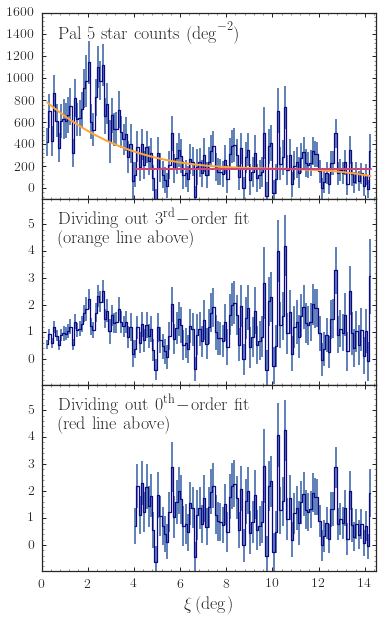

In [102]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,10)
xrange=[0.,14.5]
# First plot the data
subplot(3,1,1)
tindx= (data[:,0] > 0.2)*(data[:,0] < 14.35)
bovy_plot.bovy_plot(data[tindx,0],data[tindx,1]-backg,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-95.,1600.])
errorbar(data[tindx,0],data[tindx,1]-backg,data_err[tindx,1],
        marker='None',ls='None')
# Show continuum fits
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=3,w=1./data_err[tindx,1])
xxs= numpy.linspace(0.25,14.25,201)
plot(xxs,pp(xxs),'-',color=cm.plasma(0.8),lw=2.)
tindx= (data[:,0] > 4.)*(data[:,0] < 14.35)
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=0,w=1./data_err[tindx,1])
xxs= numpy.linspace(4.05,14.25,201)
plot(xxs,pp(xxs),'-',color=cm.plasma(0.5),lw=2.)
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{Pal\ 5\ star\ counts\ (deg}^{-2})$',
                   top_left=True,size=18.)
subplot(3,1,2)
tindx= (data[:,0] > 0.2)*(data[:,0] < 14.35)
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=3,w=1./data_err[tindx,1])
bovy_plot.bovy_plot(data[tindx,0],
                    (data[tindx,1]-backg)/pp(data[tindx,0]),
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95])
errorbar(data[tindx,0],(data[tindx,1]-backg)/pp(data[tindx,0]),
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{Dividing\ out\ 3}^\mathrm{rd}\!-\!\mathrm{order\ fit}$'
                    +'\n'+r'$\mathrm{(orange\ line\ above)}$',
                   top_left=True,size=18.)
subplot(3,1,3)
tindx= (data[:,0] > 4.)*(data[:,0] < 14.35)
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=0,w=1./data_err[tindx,1])
bovy_plot.bovy_plot(data[tindx,0],
                    (data[tindx,1]-backg)/pp(data[tindx,0]),
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95],
                    xlabel=r'$\xi\,(\mathrm{deg})$')
errorbar(data[tindx,0],(data[tindx,1]-backg)/pp(data[tindx,0]),
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
bovy_plot.bovy_text(r'$\mathrm{Dividing\ out\ 0}^\mathrm{th}\!-\!\mathrm{order\ fit}$'
                    +'\n'+r'$\mathrm{(red\ line\ above)}$',
                   top_left=True,size=18.)
subplots_adjust(hspace=0.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5_starcounts.pdf'),
                bbox_inches='tight')

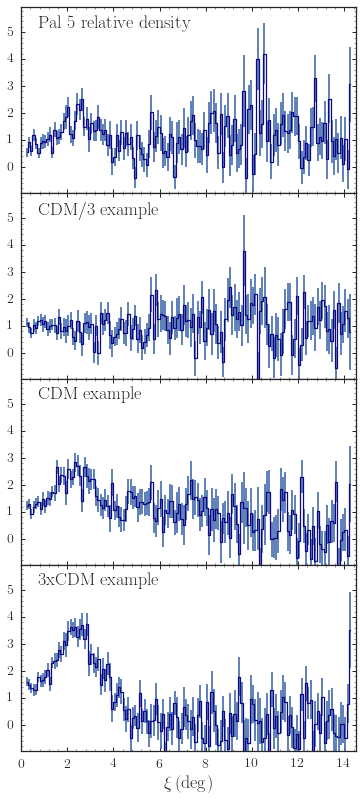

In [329]:
numpy.random.seed(10023)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,10./3.*4.)
xrange=[0.,14.5]
# First plot the data
subplot(4,1,1)
tindx= (data[:,0] > 0.2)*(data[:,0] < 14.35)
pp= Polynomial.fit(data[tindx,0],data[tindx,1]-backg,
                   deg=3,w=1./data_err[tindx,1])
bovy_plot.bovy_plot(data[tindx,0],
                    (data[tindx,1]-backg)/pp(data[tindx,0]),
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95])
errorbar(data[tindx,0],(data[tindx,1]-backg)/pp(data[tindx,0]),
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{Pal\ 5\ relative\ density}$',
                   top_left=True,size=18.)
# Few random ones
subplot(4,1,2)
xixi,tdens= read_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp33_6-9_dens.dat'),
                      indx=101)
tdens+= numpy.random.normal(size=len(xixi))*data_err[tindx,1]/pp(data[tindx,0])
bovy_plot.bovy_plot(xixi,tdens,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95])
errorbar(xixi,tdens,
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{CDM/3\ example}$',top_left=True,size=18.)
subplot(4,1,3)
xixi,tdens= read_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_6-9_dens.dat'),
                      indx=122)
tdens+= numpy.random.normal(size=len(xixi))*data_err[tindx,1]/pp(data[tindx,0])
bovy_plot.bovy_plot(xixi,tdens,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95])
errorbar(xixi,tdens,
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
gca().xaxis.set_major_formatter(plt.NullFormatter())
bovy_plot.bovy_text(r'$\mathrm{CDM\ example}$',top_left=True,size=18.)
subplot(4,1,4)
xixi,tdens= read_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm3_6-9_dens.dat'),
                      indx=14)
tdens+= numpy.random.normal(size=len(xixi))*data_err[tindx,1]/pp(data[tindx,0])
bovy_plot.bovy_plot(xixi,tdens,
                    ls='steps-mid',color=cm.plasma(0.),lw=1.25,
                    gcf=True,xrange=xrange,
                    yrange=[-.95,5.95],
                    xlabel=r'$\xi\,(\mathrm{deg})$')
errorbar(xixi,tdens,
         data_err[tindx,1]/pp(data[tindx,0]),
        marker='None',ls='None')
bovy_plot.bovy_text(r'$\mathrm{3xCDM\ example}$',top_left=True,size=18.)
subplots_adjust(hspace=0.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5_starcountexamples.pdf'),
                bbox_inches='tight')

In [106]:
def plot_dens_data(color=sns.color_palette()[0],zorder=10,marker='o',
                   poly_deg=3,minxi=0.25,
                   err_color=0.7,err_zorder=0,err=False):
    """Plots the power spectrum of the data"""
    # Read the data
    backg= 400.
    data= numpy.loadtxt('data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] > minxi-0.05)*(data[:,0] < 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    ll= data[:,0]
    px, py= signal.csd(tdata,tdata,
                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                        nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    loglog(px,py,marker=marker,color=color,zorder=zorder)
    return None

## A smooth-stream model in the presence of pericentric stripping

In [109]:
obs= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],
               radec=True,ro=R0,vo=V0,
               solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=MWPotential2014,b=0.8)
sigv= 0.5 # km/s, not actually used...
sdf_peri= \
    custom_stripping_df.streamdf_pal5_jason(sigv/V0,progenitor=obs,
                                            pot=MWPotential2014,aA=aAI,
                                            leading=False,nTrackChunks=21,
                                            nTrackIterations=1,
                                            tdisrupt=5./bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,R0=R0,
                                            vsun=[-11.1,V0+24.,7.25],
                                            custom_transform=pal5_util._TPAL5)

In [110]:
# Generate the density profile through sampling
nsamp= 1000000
lb_sample_trailing= sdf_peri.sample(n=nsamp,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
xieta_sample_trailing= pal5_util.radec_to_pal5xieta(radec_sample_trailing[:,0],
                                                   radec_sample_trailing[:,1],
                                                   degree=True)

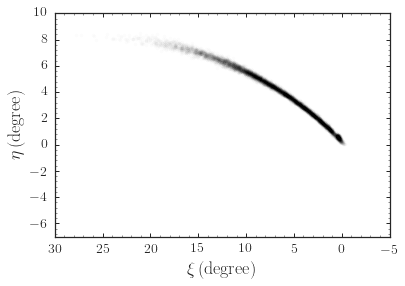

In [111]:
figsize(6,4)
bovy_plot.bovy_plot(xieta_sample_trailing[::100,0],
                    xieta_sample_trailing[::100,1],'k.',
                    alpha=0.01,zorder=0,
                    xrange=[30.,-5.],
                    yrange=[-7.,10.],
                    xlabel=r'$\xi\,(\mathrm{degree})$',
                    ylabel=r'$\eta\,(\mathrm{degree})$')

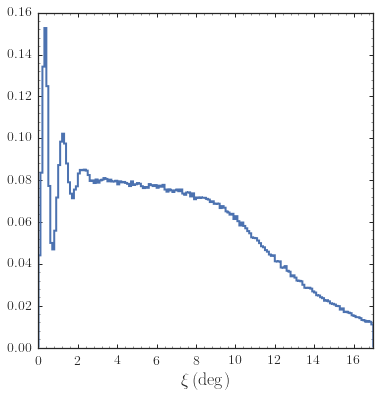

In [334]:
h,e, p= bovy_plot.bovy_hist(xieta_sample_trailing[:,0],
                            range=[0.,17.],bins=170,
                            normed=True,lw=2.,histtype='step',
                            xlabel=r'$\xi\,(\mathrm{deg})$')
sdf_peri._meandO= 0.35/bovy_conversion.freq_in_kmskpc(V0,R0)
xis= numpy.linspace(0.,17.,101)
apars= smooth_ll(xis)
dpar= numpy.array([sdf_peri.density_par(da,coord='customra') for da in apars])

In [137]:
hx= 0.5*(numpy.roll(e,-1)+e)[:-1]
def plot_peri_model(color=sns.color_palette()[0],zorder=10,marker='o',
                    poly_deg=3,minxi=0.25):
    # Read and prep data
    indx= (hx > minxi-0.05)*(hx < 14.35)
    tdata= h[indx]
    # Compute power spectrum
    pp= Polynomial.fit(hx[indx],tdata,deg=poly_deg)
    tdata/= pp(hx[indx])
    ll= hx
    px, py= signal.csd(tdata,tdata,
                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                       nperseg=len(tdata))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    print py[1:3]
    loglog(px,py,marker=marker,color=color,zorder=zorder)
    return None

[ 0.0744794   0.06852373]
[ 0.77363833  0.24737546]


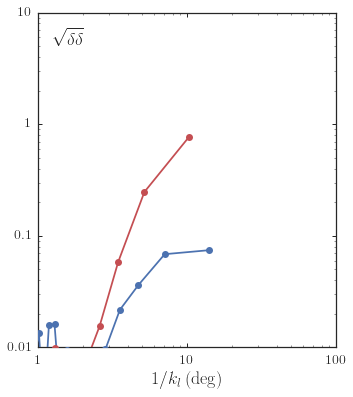

In [139]:
plot_peri_model()
plot_peri_model(color=sns.color_palette()[2],poly_deg=0,minxi=4.)
set_ranges_and_labels_dens()

## Density

In [199]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')

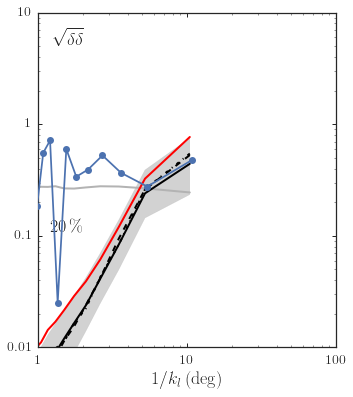

In [229]:
minxi= 4.
poly_deg= 0
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11/3.,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.15,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X5_5-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=2,ls='-',err_color='0.7',
          fill=True,err=0.6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_5-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=1,ls='--',err=None)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X15_5-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=1,ls='-.',err=None)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X5_cdm3_5-9_dens.dat'),
          poly_deg=poly_deg,
          color='r',zorder=2,ls='-',err=None)
plot_dens_data(poly_deg=poly_deg,minxi=minxi)
set_ranges_and_labels_dens()
bovy_plot.bovy_text(1.2,0.11,r'$20\,\%$',size=18.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_densObs.pdf'))

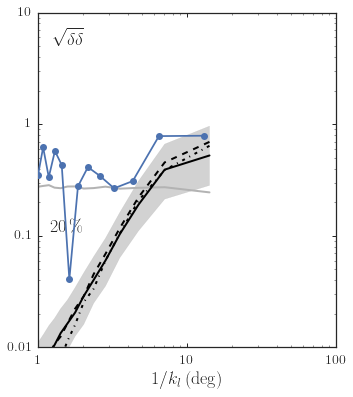

In [332]:
minxi= 0.25
poly_deg= 3
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11/3.,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.15,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X5_5-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=2,ls='-',err_color='0.7',
          fill=True,err=0.6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_5-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=1,ls='--',err=None)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=1,ls='-.',err=None)
plot_dens_data(poly_deg=poly_deg,minxi=minxi)
set_ranges_and_labels_dens()
bovy_plot.bovy_text(1.2,0.11,r'$20\,\%$',size=18.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_densObs.pdf'))

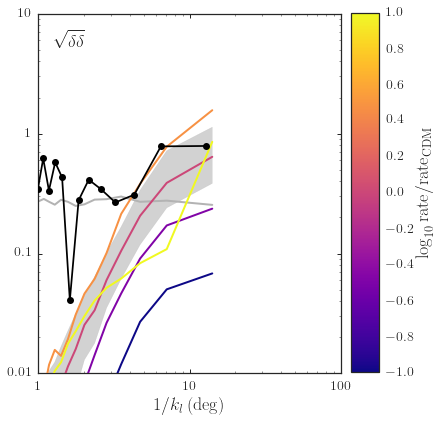

In [331]:
basefilename_pal5= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
minxi= 0.25
poly_deg= 3
figsize(16/3.,6)
plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True,err=0.6,err_color='0.7')
plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp33_6-9_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9,err=None)
plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm3_6-9_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10,err=None)
plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdmp1_6-9_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9,err=None)
plot_dens(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_cdm10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(1.,cmap,-1.,1.),zorder=10,err=None)
plot_dens_data(color='k',zorder=20,poly_deg=poly_deg,minxi=minxi)
set_ranges_and_labels_dens()
tight_layout()
add_colorbar_dens(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=False)

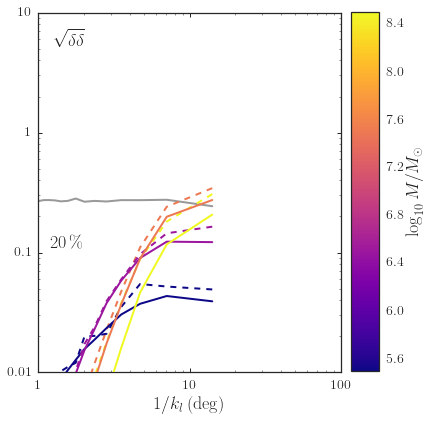

In [335]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
poly_deg= 0
cmap= cm.plasma
if save_figures:
    figsize(14.5/3.,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X5_5.5_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(5.5,cmap,5.5,8.5),zorder=7,
          err=0.6,err_color='0.6')
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_5.5_dens.dat'),
          poly_deg=poly_deg,ls='--',
          color=color_from_colormap(5.5,cmap,5.5,8.5),zorder=7)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X5_6.5_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(6.5,cmap,5.5,8.5),zorder=7)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6.5_dens.dat'),
          poly_deg=poly_deg,ls='--',
          color=color_from_colormap(6.5,cmap,5.5,8.5),zorder=7)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X5_7.5_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(7.5,cmap,5.5,8.5),zorder=7)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_7.5_dens.dat'),
          poly_deg=poly_deg,ls='--',
          color=color_from_colormap(7.5,cmap,5.5,8.5),zorder=6)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X5_8.5_dens.dat'),
          poly_deg=poly_deg,
          color=color_from_colormap(8.5,cmap,5.5,8.5),zorder=7)
plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_8.5_dens.dat'),
          poly_deg=poly_deg,ls='--',
          color=color_from_colormap(8.5,cmap,5.5,8.5),zorder=6)
set_ranges_and_labels_dens()
bovy_plot.bovy_text(1.2,0.11,r'$20\,\%$',size=18.)
if not save_figures: tight_layout()
add_colorbar_dens(5.5,8.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_densObs_massranges.pdf'))

## Constrain the rate with Pal 5

In [208]:
# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space
def kde_epanechnikov(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    y= numpy.log((1.1+x)/(1.1-x))
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
#    return numpy.sum(1./numpy.sqrt(2.*numpy.pi)/h*numpy.exp(-0.5*r**2.),axis=1)*(1./(1.1+x)+1./(1.1-x))
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

Using 1425 simulations to determine the rate PDF


(0.0, 1.5)

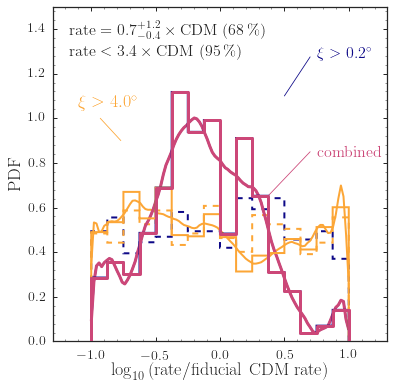

In [333]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,6.)
# Cuts for ABC
xmax, ymax, zmax= 0.15,0.15,100.
bins= 16
combw= 1.#0.5
kernel_width= 0.4
# Load results from full xi range, poly=3 and from the xi > 4, poly=0 part
abc_full= run_pal5_abc.load_abc(\
    '/Users/bovy/data/streamgap-pepper/pal5_abc/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat')
abc_end= run_pal5_abc.load_abc(\
    '/Users/bovy/data/streamgap-pepper/pal5_abc/abc/pal5_t64sampling_X10_6-9_polydeg0_minxi4p05_abc.dat')
print("Using %i simulations to determine the rate PDF" % (len(abc_full)//100+len(abc_end)//100))
# ABC:
rate_full= abc_full[(abc_full[:,1] < xmax)*(abc_full[:,2] < ymax)*(abc_full[:,3] < zmax),0]
rate_end = abc_end [(abc_end [:,1] < xmax)*(abc_end [:,2] < ymax)*(abc_end [:,3] < zmax),0]
# Plot histograms of PDF for both
h1,e,p= bovy_plot.bovy_hist(rate_full,
                            range=[-1.,1.],normed=True,color=cm.plasma(0.),
                            bins=bins,histtype='step',lw=2.,zorder=3,
                            xlabel=r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$',
                           ylabel=r'$\mathrm{PDF}$')
xxs= numpy.linspace(-0.999,0.999,101)
kdey_full= kde_epanechnikov(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))
kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
plot(xxs,kdey_full,'-',lw=2.,color=cm.plasma(0.))
plot()
dum= bovy_plot.bovy_hist(abc_full[:,0],range=[-1.,1.],histtype='step',
                         normed=True,lw=2.,overplot=True,bins=bins,zorder=0,
                         color=cm.plasma(0.),ls='--')
h2,e,p= bovy_plot.bovy_hist(abc_end[(abc_end[:,1] < xmax)*(abc_end[:,2] < ymax)*(abc_end[:,3] < zmax),0],
                            range=[-1.,1.],normed=True,color=cm.plasma(.8),
                            bins=bins,histtype='step',lw=2.,zorder=3,overplot=True)
xxs= numpy.linspace(-0.999,0.999,101)
kdey_end= kde_epanechnikov(xxs,kernel_width,numpy.log((1.1+rate_end)/(1.1-rate_end)))
kdey_end/= numpy.sum(kdey_end)*(xxs[1]-xxs[0])                    
plot(xxs,kdey_end,'-',lw=2.,color=cm.plasma(.8))
dum= bovy_plot.bovy_hist(abc_end[:,0],range=[-1.,1.],histtype='step',
                         normed=True,lw=2.,overplot=True,bins=bins,zorder=0,
                        color=cm.plasma(.8),ls='--')
combx= e
comby= numpy.hstack(((combw*h1+(1-combw)*h2),numpy.array([(combw*h1+(1-combw)*h2)[-1]])))
plot(combx,comby,ls='steps-post',zorder=5,color=cm.plasma(0.5),lw=3.)
plot(xxs,combw*kdey_full+(1.-combw)*kdey_end,'-',lw=3.,color=cm.plasma(.5))
plot([-1.,-1.],[0.,comby[0],],color=cm.plasma(0.5),lw=3.,zorder=5)
plot([1.,1.],[0.,comby[-1],],color=cm.plasma(0.5),lw=3.,zorder=5)
# Get 95% upper limit
cp= numpy.hstack(([0.],numpy.cumsum(combw*h1+(1.-combw)*h2)/numpy.sum(combw*h1+(1.-combw)*h2)))
uplim= interpolate.InterpolatedUnivariateSpline(cp,e)(0.95)
cp= numpy.cumsum(combw*kdey_full+(1.-combw)*kdey_end)\
        /numpy.sum(combw*kdey_full+(1.-combw)*kdey_end)
uplim_68= interpolate.InterpolatedUnivariateSpline(cp,xxs)(0.68)
uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs)(0.95)
bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                    % (10.**interpolate.InterpolatedUnivariateSpline(cp,xxs)(0.5),
                       10.**interpolate.InterpolatedUnivariateSpline(cp,xxs)(0.84)\
                        -10.**interpolate.InterpolatedUnivariateSpline(cp,xxs)(0.5),
                       10.**interpolate.InterpolatedUnivariateSpline(cp,xxs)(0.5)\
                        -10.**interpolate.InterpolatedUnivariateSpline(cp,xxs)(0.16))
                    +'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                   size=16.,top_left=True)
xlim(-1.3,1.3)
# Label the curves
plot([0.5,0.7],[1.1,1.275],color=cm.plasma(0.),lw=.8)
bovy_plot.bovy_text(0.75,1.275,r'$\xi > 0.2^\circ$',size=16.,color=cm.plasma(0.))
plot([-0.77,-0.93],[0.9,1.],color=cm.plasma(.8),lw=.8)
bovy_plot.bovy_text(-1.1,1.05,r'$\xi > 4.0^\circ$',size=18.,color=cm.plasma(.8))
plot([0.37,0.7],[0.65,0.85],color=cm.plasma(0.5),lw=.8)
bovy_plot.bovy_text(0.75,0.825,r'$\mathrm{combined}$',size=16.,color=cm.plasma(0.5))
ylim(0.,1.5)

Using 1130 simulations to determine the rate PDF


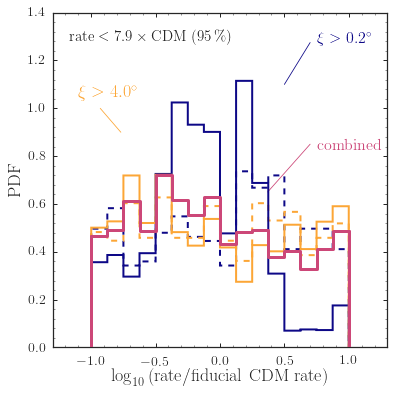

In [207]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,6.)
# Cuts for ABC
xmax, ymax, zmax= 0.2,0.2,100.
bins= 16
combw= 0.25
# Load results from full xi range, poly=3 and from the xi > 4, poly=0 part
abc_full= run_pal5_abc.load_abc(\
    '/Users/bovy/data/streamgap-pepper/pal5_abc/abc/pal5_t64sampling_X10_6-9_polydeg3_minxi0p25_abc.dat')
abc_end= run_pal5_abc.load_abc(\
    '/Users/bovy/data/streamgap-pepper/pal5_abc/abc/pal5_t64sampling_X10_6-9_polydeg0_minxi4p05_abc.dat')
print("Using %i simulations to determine the rate PDF" % (len(abc_full)//100+len(abc_end)//100))
# Plot histograms of PDF for both
h1,e,p= bovy_plot.bovy_hist(abc_full[(abc_full[:,1] < xmax)*(abc_full[:,2] < ymax)*(abc_full[:,3] < zmax),0],
                            range=[-1.,1.],normed=True,color=cm.plasma(0.),
                            bins=bins,histtype='step',lw=2.,zorder=3,
                            xlabel=r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$',
                           ylabel=r'$\mathrm{PDF}$')
dum= bovy_plot.bovy_hist(abc_full[:,0],range=[-1.,1.],histtype='step',
                         normed=True,lw=2.,overplot=True,bins=bins,zorder=0,
                         color=cm.plasma(0.),ls='--')
h2,e,p= bovy_plot.bovy_hist(abc_end[(abc_end[:,1] < xmax)*(abc_end[:,2] < ymax)*(abc_end[:,3] < zmax),0],
                            range=[-1.,1.],normed=True,color=cm.plasma(.8),
                            bins=bins,histtype='step',lw=2.,zorder=3,overplot=True)
dum= bovy_plot.bovy_hist(abc_end[:,0],range=[-1.,1.],histtype='step',
                         normed=True,lw=2.,overplot=True,bins=bins,zorder=0,
                        color=cm.plasma(.8),ls='--')
combx= e
comby= numpy.hstack(((combw*h1+(1-combw)*h2),numpy.array([(combw*h1+(1-combw)*h2)[-1]])))
plot(combx,comby,ls='steps-post',zorder=5,color=cm.plasma(0.5),lw=3.)
plot([-1.,-1.],[0.,comby[0],],color=cm.plasma(0.5),lw=3.,zorder=5)
plot([1.,1.],[0.,comby[-1],],color=cm.plasma(0.5),lw=3.,zorder=5)
# Get 95% upper limit
cp= numpy.hstack(([0.],numpy.cumsum(combw*h1+(1.-combw)*h2)/numpy.sum(combw*h1+(1.-combw)*h2)))
uplim= interpolate.InterpolatedUnivariateSpline(cp,e)(0.95)
cp= numpy.hstack(([0.],numpy.cumsum(h2)/numpy.sum(h2)))
uplim_end= interpolate.InterpolatedUnivariateSpline(cp,e)(0.95)
bovy_plot.bovy_text(r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim),
                   size=15.,top_left=True)
xlim(-1.3,1.3)
# Label the curves
plot([0.5,0.7],[1.1,1.275],color=cm.plasma(0.),lw=.8)
bovy_plot.bovy_text(0.75,1.275,r'$\xi > 0.2^\circ$',size=16.,color=cm.plasma(0.))
plot([-0.77,-0.93],[0.9,1.],color=cm.plasma(.8),lw=.8)
bovy_plot.bovy_text(-1.1,1.05,r'$\xi > 4.0^\circ$',size=18.,color=cm.plasma(.8))
plot([0.37,0.7],[0.65,0.85],color=cm.plasma(0.5),lw=.8)
bovy_plot.bovy_text(0.75,0.825,r'$\mathrm{combined}$',size=16.,color=cm.plasma(0.5))

## Track autocorrelation

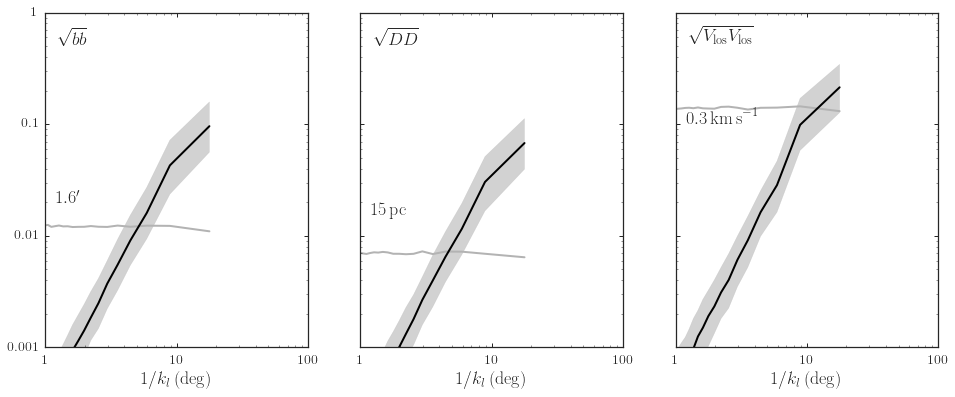

In [59]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(13,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.975,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track(os.path.join(basefilename,'pal5_t64sampling_X5_5-9_omega.dat'),
               color='k',zorder=1,ls='-',err_color='0.7',
               fill=True,errs=[0.026,0.015,0.3])
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.02,r"$1.6'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.015,r'$15\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.1,r'$0.3\,\mathrm{km\,s}^{-1}$',size=18.)
set_ranges_and_labels()
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_trackObs.pdf'))

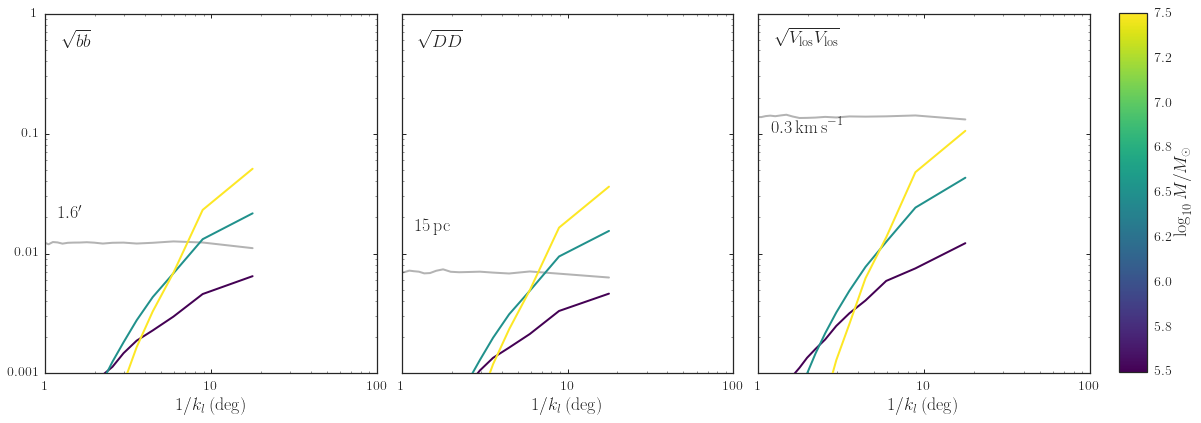

In [68]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track(os.path.join(basefilename,'pal5_t64sampling_X5_5.5_omega.dat'),
               color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,err_color='0.7',
               errs=[0.026,0.015,0.3])
plot_all_track(os.path.join(basefilename,'pal5_t64sampling_X5_6.5_omega.dat'),
               color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7)
plot_all_track(os.path.join(basefilename,'pal5_t64sampling_X5_7.5_omega.dat'),
               color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7)
set_ranges_and_labels()
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.011,r"$1.6'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.08,r'$15\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.15,r'$0.3\,\mathrm{km\,s}^{-1}$',size=18.)
if not save_figures: tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_trackObs_massranges.pdf'))

## Density-track cross-correlation

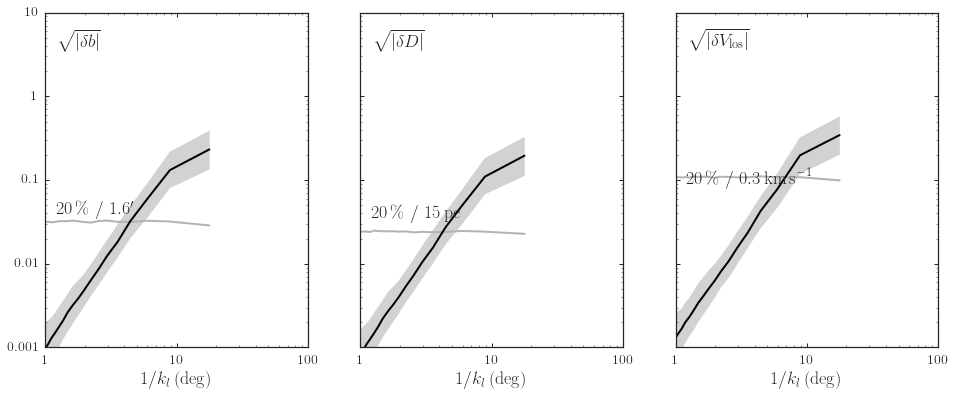

In [61]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(13,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.975,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track_dens(os.path.join(basefilename,'pal5_t64sampling_X5_5-9_dens.dat'),
                    color='k',zorder=1,ls='-',err_color='0.7',
                    fill=True,err1=0.2,err2s=[0.026,0.015,0.3])
set_ranges_and_labels_cross()
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.04,r"$20\,\%\ / \ 1.6'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.035,r'$20\,\%\ / \ 15\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.13,r'$20\,\%\ / \ 0.3\,\mathrm{km\,s}^{-1}$',size=18.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_crossObs.pdf'))

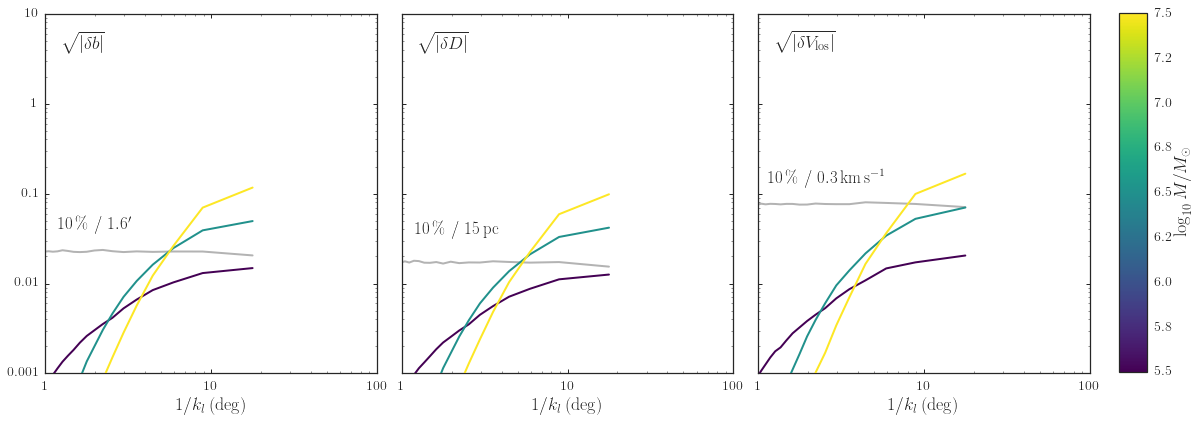

In [70]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track_dens(os.path.join(basefilename,'pal5_t64sampling_X5_5.5_dens.dat'),
               color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,err_color='0.7',
               err1=0.2,err2s=[0.026,0.015,0.3])
plot_all_track_dens(os.path.join(basefilename,'pal5_t64sampling_X5_6.5_dens.dat'),
               color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7)
plot_all_track_dens(os.path.join(basefilename,'pal5_t64sampling_X5_7.5_dens.dat'),
               color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7)
set_ranges_and_labels_cross()
if not save_figures: tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.04,r"$20\,\%\ / \ 1.6'$",size=17.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.035,r'$20\,\%\ / \ 15\,\mathrm{pc}$',size=17.)
subplot(1,3,3)
bovy_plot.bovy_text(1.15,0.13,r'$20\,\%\ / \ 0.3\,\mathrm{km\,s}^{-1}$',size=17.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','pal5like_crossObs_massranges.pdf'))

## Bispectra

In [49]:
def median_bispectrum(filename,ind,scatter=False,limitnsim=None,err=None):
    # Compute the median bispectrum
    data1= read_data(filename)
    if 'dens' in filename:
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    apars= data1[0]
    tdata= (data1[2:]/data1[1]).T
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    if 'dens' in filename:
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2])
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],1)
    Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata1,tdata1)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
    if not limitnsim is None: nsim= limitnsim
    ppyr= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyi= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyr_err= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyi_err= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    for ii in range(nsim):
        if 'dens' in filename:
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii])
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],1)
        Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata1,tdata1)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
        ppyr[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
        ppyi[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
        # Same for error
        if not err is None:
            tmock= err*numpy.random.normal(size=len(ll))
            Bspec, px= bispectrum.bispectrum(numpy.vstack((tmock,tmock)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
            ppyr_err[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
            ppyi_err[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
    ppyr_err.sort(axis=0)
    ppyi_err.sort(axis=0)
    if not scatter:
        return (1./px[len(Bspec)//2:]*(ll[1]-ll[0]),
                numpy.nanmedian(ppyr,axis=0),
                numpy.nanmedian(ppyi,axis=0),
                ppyr_err[int(numpy.round(0.9545*nsim))],
                ppyi_err[int(numpy.round(0.9545*nsim))])
    else:
        ppyr.sort(axis=0)
        ppyi.sort(axis=0)
        return (1./px[len(Bspec)//2:]*(ll[1]-ll[0]),
                numpy.nanmedian(ppyr,axis=0),
                numpy.nanmedian(ppyi,axis=0),
                ppyr[int(numpy.round(0.25*nsim))],
                ppyr[int(numpy.round(0.75*nsim))],
                ppyi[int(numpy.round(0.25*nsim))],
                ppyi[int(numpy.round(0.75*nsim))])

In [63]:
def plot_all_bispectrum(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        err_color=sns.color_palette()[2],err_zorder=0,
                        scale=1.,ind=3,nsim=None,errs=[0.2,0.026]):
    subplot(1,4,1)
    px, pyr, pyi, pyr_err, pyi_err= median_bispectrum(filename,ind,
                                                      limitnsim=nsim,err=errs[0])
    loglog(px,scale*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*pyr_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    subplot(1,4,2)
    loglog(px,scale*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*pyi_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        subplot(1,4,1)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename,ind,scatter=True,
                                                                     limitnsim=nsim)
        fill_between(plotx,scale*lowr,scale*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,2)
        fill_between(plotx,scale*lowi,scale*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,4,3)
    px, pyr, pyi, pyr_err, pyi_err= median_bispectrum(filename.replace('dens','omega'),ind,
                                                      limitnsim=nsim,err=errs[1])
    loglog(px,100.*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,100.*pyr_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    subplot(1,4,4)
    loglog(px,100.*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,100.*pyi_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        subplot(1,4,3)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename.replace('dens','omega'),
                                                                     ind,scatter=True,limitnsim=nsim)
        fill_between(plotx,100.*lowr,100.*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,4)
        fill_between(plotx,100.*lowi,100.*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_bispectrum(high=20.):
    subplot(1,4,1)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,4,2)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,3)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(bbb)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,4)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(bbb)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.0001,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def add_colorbar_bispectrum(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.925)
        cbar_ax = fig.add_axes([0.99, 0.13, 0.025, 0.845])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

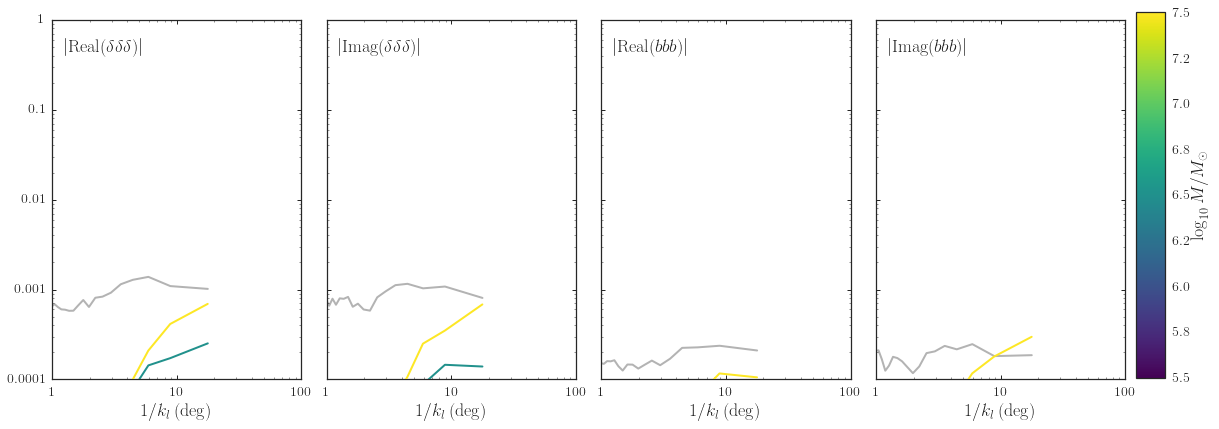

In [75]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(12,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.1)
else:
    figsize(16,6)
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_5.5_dens.dat'),
                    color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,nsim=101,
                    err_color='0.7')
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_6.5_dens.dat'),
                    color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7,nsim=101,
                    errs=[None,None])
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_7.5_dens.dat'),
                    color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7,nsim=101,
                    errs=[None,None])
set_ranges_and_labels_bispectrum(high=1.)
if not save_figures: tight_layout()
add_colorbar_bispectrum(5.5,7.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'pal5like_bispectrum_obs_massranges.pdf'))
else:
    tight_layout()

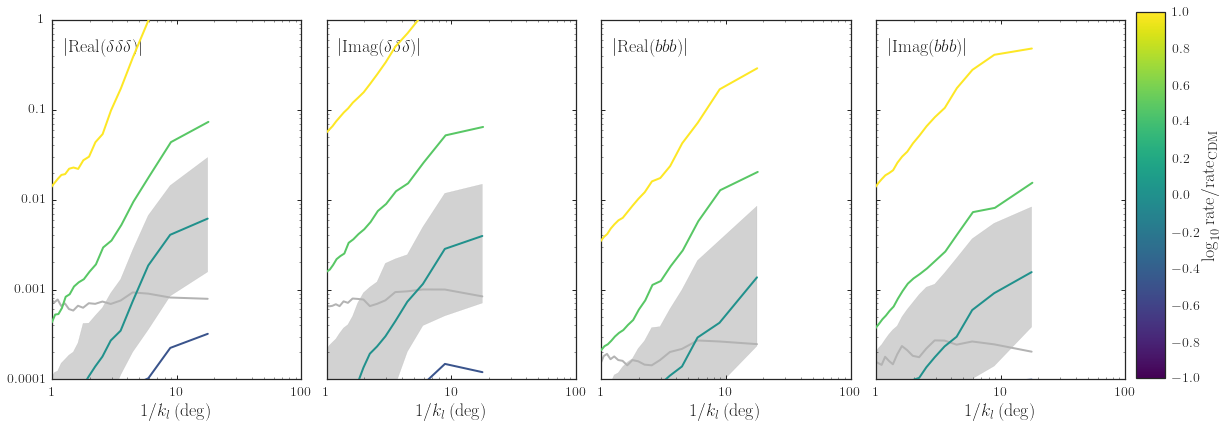

In [74]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(12,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.1)
else:
    figsize(16,6)
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_5-9_dens.dat'),
                    color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True,nsim=101,
                    err_color='0.7')
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_cdmp33_5-9_dens.dat'),
                    color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9,nsim=101,
                    errs=[None,None])
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_cdm3_5-9_dens.dat'),
                    color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10,nsim=101,
                    errs=[None,None])
#plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_cdmp1_5-9_dens.dat'),
#                    color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9,nsim=None,
#                    errs=[None,None])
plot_all_bispectrum(os.path.join(basefilename,'pal5_t64sampling_X5_cdm10_5-9_dens.dat'),
                    color=color_from_colormap(1.,cmap,-1.,1.),zorder=10,nsim=101,
                    errs=[None,None])
set_ranges_and_labels_bispectrum(high=1.)
if not save_figures: tight_layout()
add_colorbar_bispectrum(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'pal5like_bispectrum_obs_rate.pdf'))
else:
    tight_layout()